In [14]:
import sys
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import urllib
from matplotlib import pyplot as plt

In [13]:
CWD_PATH = os.getcwd()
# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
PATH_TO_CKPT = os.path.join(CWD_PATH, 'modules', MODEL_NAME, 'frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(CWD_PATH, '../../tensorflow', 'models', 'research', 'object_detection', 'data', 'mscoco_label_map.pbtxt')
IMAGE_SIZE = (12, 8)

In [3]:
sys.path.append(os.path.join(CWD_PATH, '../../tensorflow','models', 'research'))
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)
    ).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [9]:
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [17]:
image_path = './stanford-car-dataset-by-classes-folder/car_data/Acura Integra_Type_R Coupe 2001/04471.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8
)

array([[[108, 107, 113],
        [104, 103, 109],
        [106, 105, 111],
        ..., 
        [106,  89,  63],
        [120, 105,  74],
        [126, 111,  78]],

       [[104, 103, 109],
        [102, 101, 107],
        [104, 103, 109],
        ..., 
        [125, 109,  83],
        [123, 110,  78],
        [128, 115,  81]],

       [[102, 101, 107],
        [101, 100, 106],
        [101, 100, 106],
        ..., 
        [140, 126,  99],
        [132, 121,  89],
        [128, 118,  83]],

       ..., 
       [[ 85,  79,  53],
        [ 75,  76,  45],
        [110, 106,  77],
        ..., 
        [ 75,  74,  80],
        [ 68,  67,  73],
        [ 78,  77,  83]],

       [[ 78,  70,  51],
        [ 74,  69,  47],
        [ 88,  82,  60],
        ..., 
        [ 77,  76,  82],
        [ 71,  70,  76],
        [ 78,  77,  83]],

       [[ 84,  72,  58],
        [ 72,  63,  48],
        [ 77,  68,  51],
        ..., 
        [ 81,  78,  85],
        [ 75,  72,  79],
        [ 77,  74,

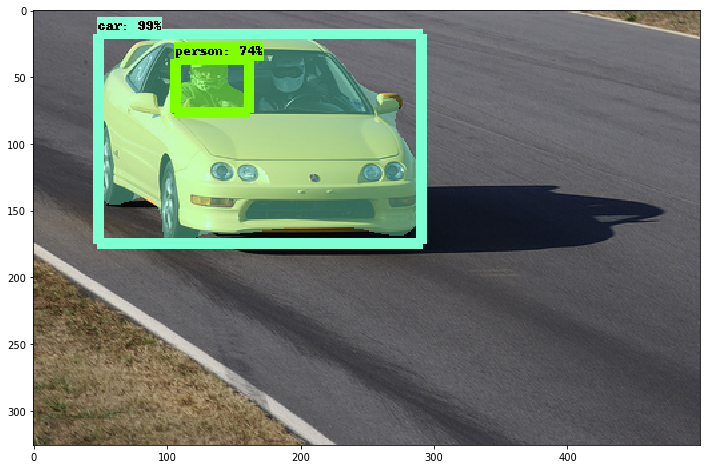

In [29]:
# need to use matplotlib inline if want to show at jupyter Notebook
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
plt.show()